# TS Prophet

In [1]:
%matplotlib inline
import pandas as pd
from prophet import Prophet

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# sns.set_style(
#     style='darkgrid', 
#     rc={'axes.facecolor': 'white', 'grid.color': '.8'}
# )
# NF_ORANGE = '#ff5a36'
# NF_BLUE = '#163251'
# cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
# sns.set_palette(palette=cmaps_hex)
# sns_c = sns.color_palette(palette=cmaps_hex)
# %matplotlib inline
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

# plt.rcParams['figure.figsize'] = [12, 6]
# plt.rcParams['figure.dpi'] = 100

In [3]:
# Load data
df = pd.read_csv("../data/preprocessed/Building_4.csv").astype({'datetime': 'datetime64'})#.set_index('datetime')

In [4]:
# Add a total load
df['total_load_kWh'] = df['equipment_electric_power_kWh'] + df['dhw_heating_kWh'] + df['cooling_load_kWh']

# Add a total load without cooling
df['total_load_wo_cooling_kWh'] = df['equipment_electric_power_kWh'] + df['dhw_heating_kWh']

# Add a net load
df['net_load_kWh'] = df['total_load_kWh'] - df['solar_generation_kW']

<AxesSubplot:>

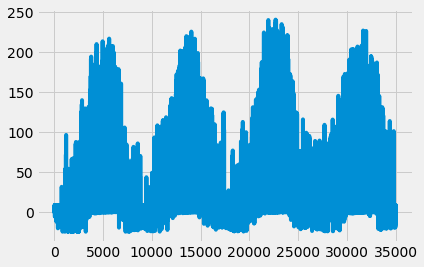

In [5]:
df['net_load_kWh'].plot()

In [6]:
df.columns

Index(['datetime', 'daylight_savings', 'indoor_temp', 'avg_unmet_cooling_temp',
       'indoor_hum', 'equipment_electric_power_kWh', 'dhw_heating_kWh',
       'cooling_load_kWh', 'solar_generation_W_kW', 'outdoor_temp',
       'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2',
       'pred_6h_outdoor_temp', 'pred_12h_outdoor_temp',
       'pred_24h_outdoor_temp', 'pred_6h_outdoor_hum', 'pred_12h_outdoor_hum',
       'pred_24h_outdoor_hum', 'pred_6h_diffuse_solar_W_m2',
       'pred_12h_diffuse_solar_W_m2', 'pred_24h_diffuse_solar_W_m2',
       'pred_6h_direct_solar_W_m2', 'pred_12h_direct_solar_W_m2',
       'pred_24h_direct_solar_W_m2', 'holiday', 'workday',
       'solar_generation_kW', 'total_load_kWh', 'total_load_wo_cooling_kWh',
       'net_load_kWh'],
      dtype='object')

In [7]:
df = df.rename(columns={'datetime':'ds',
                        'net_load_kWh':'y'})
df.head(5)

,ds,daylight_savings,indoor_temp,avg_unmet_cooling_temp,indoor_hum,equipment_electric_power_kWh,dhw_heating_kWh,cooling_load_kWh,solar_generation_W_kW,outdoor_temp,...,pred_24h_diffuse_solar_W_m2,pred_6h_direct_solar_W_m2,pred_12h_direct_solar_W_m2,pred_24h_direct_solar_W_m2,holiday,workday,solar_generation_kW,total_load_kWh,total_load_wo_cooling_kWh,y
0,2008-01-02 00:00:00,0.0,20.42,0.0,59.00,0.44,0,0.0,0.0,9.40,...,0.0,-0.00,5.32,0.0,True,False,0.0,0.44,0.44,0.44
1,2008-01-02 01:00:00,0.0,20.16,0.0,59.61,0.44,0,0.0,0.0,7.61,...,0.0,1.11,2.04,-0.0,True,False,0.0,0.44,0.44,0.44
2,2008-01-02 02:00:00,0.0,20.00,0.0,59.95,0.44,0,0.0,0.0,8.11,...,0.0,1.74,1.04,0.0,True,False,0.0,0.44,0.44,0.44
3,2008-01-02 03:00:00,0.0,19.78,0.0,60.31,0.44,0,0.0,0.0,8.36,...,-0.0,1.09,0.99,0.0,True,False,0.0,0.44,0.44,0.44
4,2008-01-02 04:00:00,0.0,19.66,0.0,60.29,0.44,0,0.0,0.0,8.78,...,0.0,1.78,0.84,0.0,True,False,0.0,0.44,0.44,0.44


In [8]:
my_model = Prophet(interval_width = 0.8, seasonality_mode="additive")

In [9]:
my_model.fit(df)

Initial log joint probability = -1196.03
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       50096.3    0.00074554       166.165      0.9207     0.09207      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       50099.9   9.68378e-05       200.231   5.554e-07       0.001      238  LS failed, Hessian reset 
     180       50100.4    6.5025e-05        130.77   2.127e-07       0.001      312  LS failed, Hessian reset 
     199       50100.8   0.000323986       73.1972      0.6913      0.6913      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     273       50102.1   3.42284e-05       102.362   3.948e-07       0.001      470  LS failed, Hessian reset 
     299       50102.2   0.000149758       86.4234      0.9864      0.9864      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

In [10]:
future_dates = my_model.make_future_dataframe(periods = 24*365, freq='H',include_history=False)
future_dates.tail()

,ds
8755,2012-12-30 19:00:00
8756,2012-12-30 20:00:00
8757,2012-12-30 21:00:00
8758,2012-12-30 22:00:00
8759,2012-12-30 23:00:00


In [11]:
forecast = my_model.predict(future_dates)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
8755,2012-12-30 19:00:00,-11.407636,-57.277112,34.978590
8756,2012-12-30 20:00:00,-22.315277,-68.367098,21.791771
8757,2012-12-30 21:00:00,-29.196680,-74.773901,16.221132
8758,2012-12-30 22:00:00,-33.033159,-79.704291,10.907499
8759,2012-12-30 23:00:00,-35.122198,-80.096491,10.076434


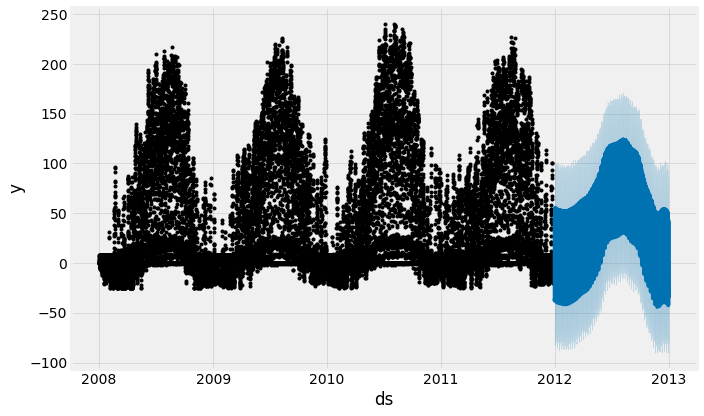

In [12]:
fig = my_model.plot(forecast, uncertainty=True)

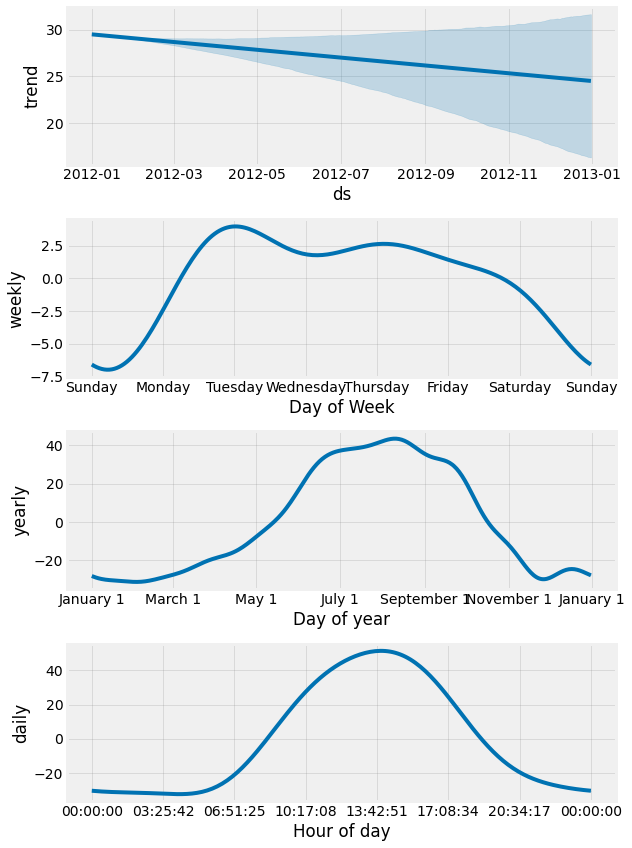

In [13]:
fig = my_model.plot_components(forecast)

In [14]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(my_model, forecast)